In [1]:
import utilities
import os
import json
import statistics
from prettytable import PrettyTable
from prettytable import ALL as ALL
# from scipy.stats import ttest_ind as ttest

In [2]:
# !pip3 install prettytable

In [350]:
DATA_DIR = '/media/umar/Data/work/voice-assistant-central/voice-assistants-openwpm/'
# DATA_DIR = '/media/umar/Data/work/voice-assistant-central/data/crawled-data-first-trained/'
RESULTS_DIR = '/media/umar/Data/work/voice-assistant-central/data/results/'

### Personas
```
Connected-Car
Dating
Fashion-Style
Pets-Animals
Religion-Spirituality
SmartHome
Wine-Beverages
Health-Fitness
Navigation-TripPlanners
```

In [351]:
control_list = ['Plain', 'Plain-One', 'Plain-Two', 'Amazon-Only', 'No-Skill']
# control_list = ['Plain', 'Amazon-Only', 'No-Skill']
test_list = ['Connected-Car', 'Dating', 'Fashion-Style', 'Pets-Animals', 'Religion-Spirituality', 'SmartHome', 'Wine-Beverages','Health-Fitness', 'Navigation-TripPlanners']

In [352]:
def get_forced_normal_websites_with_bids(bid_files):
    forced_count = 0
    normal_count = 0
    for bid_file in bid_files:
        if 'FORCED' in bid_file:
            forced_count += 1
        else:
            normal_count += 1

    return str(normal_count) + '/' + str(forced_count)


def get_websites_with_bids(bid_files):
    websites_with_bids = []
    for bid_file in bid_files:
        websites_with_bids.append(bid_file.rsplit('/', 1)[1].rsplit('_', 1)[1])

    return websites_with_bids


def return_bid_cpms(bid_files):
    bid_cpms = []
    for bid_file in bid_files:
        all_bids = utilities.read_file(bid_file)

        for bid in all_bids:
            bid_json = json.loads(bid)
            bid_cpms.append(bid_json['cpm'])
    
    return bid_cpms


def return_bid_cpms_websites(bid_files, websites = []):
    bid_cpms = []
    
    for bid_file in bid_files:
        bid_website = bid_file.rsplit('/', 1)[1].rsplit('_', 1)[1]
        
        if len(websites) > 0 and bid_website not in websites:
            continue
            
        all_bids = utilities.read_file(bid_file)

        for bid in all_bids:
            bid_json = json.loads(bid)
            bid_cpms.append(bid_json['cpm'])
    
    return bid_cpms


def return_bid_cpms_advertisers(bid_files, advertisers, websites = []):
    bid_cpms = {}
    
    for bid_file in bid_files:
        bid_website = bid_file.rsplit('/', 1)[1].rsplit('_', 1)[1]
        
        if len(websites) > 0 and bid_website not in websites:
            continue
            
        all_bids = utilities.read_file(bid_file)

        for bid in all_bids:
            bid_json = json.loads(bid)
            
            if bid_json['bidder'] not in advertisers:
                continue
            
            if bid_json['bidder'] not in bid_cpms:
                bid_cpms[bid_json['bidder']] = []
            
            bid_cpms[bid_json['bidder']].append(bid_json['cpm'])
    
    return bid_cpms


def return_bid_cpms_debug(bid_files, advertisers, websites = []):
    bid_cpms = {}
    
    for bid_file in bid_files:
        bid_website = bid_file.rsplit('/', 1)[1].rsplit('_', 1)[1]
        
        if len(websites) > 0 and bid_website not in websites:
            continue
            
        all_bids = utilities.read_file(bid_file)

        for bid in all_bids:
            bid_json = json.loads(bid)
            
            if bid_json['bidder'] not in advertisers:
                continue
            
            if bid_json['bidder'] not in bid_cpms:
                bid_cpms[bid_json['bidder']] = []
            
            bid_cpms[bid_json['bidder']].append((bid_json['cpm'], bid_file.rsplit('/')[-1]))
    
    return bid_cpms


def return_median_cpms(bid_files):
    bid_cpms = []
    for bid_file in bid_files:
        all_bids = utilities.read_file(bid_file)
        
        current_bid_cpms = []
        for bid in all_bids:
            bid_json = json.loads(bid)
            current_bid_cpms.append(bid_json['cpm'])
            
        bid_cpms.append(statistics.median(current_bid_cpms))
    
    return bid_cpms


def return_median_cpms_websites(bid_files, websites = []):
    bid_cpms = []
    for bid_file in bid_files:
        all_bids = utilities.read_file(bid_file)
        
        bid_website = bid_file.rsplit('/', 1)[1].rsplit('_', 1)[1]
        if len(websites) > 0 and bid_website not in websites:
            continue
            
        current_bid_cpms = []
        for bid in all_bids:
            bid_json = json.loads(bid)
            current_bid_cpms.append(bid_json['cpm'])
            
        bid_cpms.append(statistics.median(current_bid_cpms))
    
    return bid_cpms


def return_median_cpms_advertisers(bid_files, advertisers, websites = []):
    bid_cpms = {}
    
    for bid_file in bid_files:
        all_bids = utilities.read_file(bid_file)
        
        bid_website = bid_file.rsplit('/', 1)[1].rsplit('_', 1)[1]
        if len(websites) > 0 and bid_website not in websites:
            continue
            
        current_bid_cpms = {}
        for bid in all_bids:
            bid_json = json.loads(bid)
            
            if bid_json['bidder'] not in advertisers:
                continue
            
            if bid_json['bidder'] not in bid_cpms:
                bid_cpms[bid_json['bidder']] = []
            
            if bid_json['bidder'] not in current_bid_cpms:
                current_bid_cpms[bid_json['bidder']] = []
            
            current_bid_cpms[bid_json['bidder']].append(bid_json['cpm'])
         
        for bidder in current_bid_cpms:
            bid_cpms[bidder].append(statistics.median(current_bid_cpms[bidder]))
    
    return bid_cpms


def return_common_websites(persona_list, data_dir):
    persona_dir = os.path.join(data_dir, persona_list[0] + '/website_bids/')
    common_websites = set(get_websites_with_bids(utilities.get_files_in_a_directory(persona_dir)))
    
    for persona in persona_list[1:]:
        persona_dir = os.path.join(data_dir, persona + '/website_bids/')
        candidates = get_websites_with_bids(utilities.get_files_in_a_directory(persona_dir))
        common_websites = common_websites.intersection(candidates)
        
    return common_websites


def ptable_to_csv(table, filename, headers=True):
    """Save PrettyTable results to a CSV file.

    Adapted from @AdamSmith https://stackoverflow.com/questions/32128226

    :param PrettyTable table: Table object to get data from.
    :param str filename: Filepath for the output CSV.
    :param bool headers: Whether to include the header row in the CSV.
    :return: None
    """
    raw = table.get_string()
    data = [tuple(filter(None, map(str.strip, splitline)))
            for line in raw.splitlines()
            for splitline in [line.split('|')] if len(splitline) > 1]
    if table.title is not None:
        data = data[1:]
    if not headers:
        data = data[1:]
    with open(filename, 'w') as f:
        for d in data:
            f.write('{}\n'.format(','.join(d)))

### Reading bids for personas

In [325]:
def compute_bid_statistics(persona_list, data_dir, common_websites=[], get_median=False):
    persona_stat_map = {}
    cpms_personas = {}
    
    for persona in persona_list:
        persona_stat_map[persona] = {}
        cpms_personas[persona] = set()
        
        persona_dir = os.path.join(data_dir, persona + '/website_bids/')
        
        bid_files = utilities.get_files_in_a_directory(persona_dir)
        persona_stat_map[persona]['normal-forced'] = get_forced_normal_websites_with_bids(bid_files)
        
        if get_median:
            cpms = return_median_cpms_websites(bid_files, common_websites)
        else:
            cpms = return_bid_cpms_websites(bid_files, common_websites)
            
        cpms_personas[persona] = cpms

        persona_stat_map[persona]['median'] = "{0:0.3f}".format(statistics.median(cpms))
        persona_stat_map[persona]['mean'] = "{0:0.3f}".format(statistics.mean(cpms))
        persona_stat_map[persona]['min'] = "{0:0.3f}".format(min(cpms))
        persona_stat_map[persona]['max'] = "{0:0.3f}".format(max(cpms))
        persona_stat_map[persona]['sd'] = "{0:0.3f}".format(statistics.stdev(cpms))

        persona_stat_map[persona]['total_bids'] = len(cpms)
        normal, forced = persona_stat_map[persona]['normal-forced'].split('/')
        persona_stat_map[persona]['total_websites'] = int(normal) + int(forced)
        
        persona_stat_map[persona]['common_websites'] = len(common_websites) if len(common_websites) > 0 else '-'

    return persona_stat_map, cpms_personas

In [326]:
def print_bid_statistics(persona_stat_map, persona_list):
    
    table = PrettyTable(['Measure'] + persona_list, hrules=ALL)
    
    table.add_row(['# of websites'] + [persona_stat_map[persona]['total_websites'] for persona in persona_list])
    table.add_row(['Common websites'] + [persona_stat_map[persona]['common_websites'] for persona in persona_list])
    table.add_row(['Normal/Forced'] + [persona_stat_map[persona]['normal-forced'] for persona in persona_list])
    table.add_row(['# of bids'] + [persona_stat_map[persona]['total_bids'] for persona in persona_list])
        
    table.add_row(['Median'] + [persona_stat_map[persona]['median'] for persona in persona_list])

    table.add_row(['Mean'] + [persona_stat_map[persona]['mean'] for persona in persona_list])
    table.add_row(['SD'] + [persona_stat_map[persona]['sd'] for persona in persona_list])
    table.add_row(['Min'] + [persona_stat_map[persona]['min'] for persona in persona_list])
    table.add_row(['Max'] + [persona_stat_map[persona]['max'] for persona in persona_list])
    
    print(table)
    
    return table

## Consider all websites and all bids

In [353]:
persona_stat_map, cpms_personas = compute_bid_statistics(control_list + test_list, DATA_DIR)
table = print_bid_statistics(persona_stat_map, control_list + test_list)
ptable_to_csv(table, RESULTS_DIR + 'all-bids.csv')

+-----------------+-------+-----------+-----------+-------------+----------+---------------+--------+---------------+--------------+-----------------------+-----------+----------------+----------------+-------------------------+
|     Measure     | Plain | Plain-One | Plain-Two | Amazon-Only | No-Skill | Connected-Car | Dating | Fashion-Style | Pets-Animals | Religion-Spirituality | SmartHome | Wine-Beverages | Health-Fitness | Navigation-TripPlanners |
+-----------------+-------+-----------+-----------+-------------+----------+---------------+--------+---------------+--------------+-----------------------+-----------+----------------+----------------+-------------------------+
|  # of websites  |   18  |     18    |     25    |      26     |    17    |       23      |   21   |       18      |      17      |           23          |     20    |       21       |       18       |            19           |
+-----------------+-------+-----------+-----------+-------------+----------+--------

### Consider bids on websites where bids returned for all personas

In [144]:
common_websites = return_common_websites(control_list + test_list, DATA_DIR)

persona_stat_map, cpms_personas = compute_bid_statistics(control_list + test_list, DATA_DIR, common_websites)
table = print_bid_statistics(persona_stat_map, control_list + test_list)

ptable_to_csv(table, RESULTS_DIR + 'common-bids.csv')

+-----------------+-------+-----------+-----------+-------------+----------+---------------+--------+---------------+--------------+-----------------------+-----------+----------------+----------------+-------------------------+
|     Measure     | Plain | Plain-One | Plain-Two | Amazon-Only | No-Skill | Connected-Car | Dating | Fashion-Style | Pets-Animals | Religion-Spirituality | SmartHome | Wine-Beverages | Health-Fitness | Navigation-TripPlanners |
+-----------------+-------+-----------+-----------+-------------+----------+---------------+--------+---------------+--------------+-----------------------+-----------+----------------+----------------+-------------------------+
|  # of websites  |   18  |     18    |     25    |      26     |    17    |       23      |   21   |       18      |      17      |           23          |     20    |       21       |       18       |            19           |
+-----------------+-------+-----------+-----------+-------------+----------+--------

### Consider medain bids on websites 

In [147]:
persona_stat_map, cpms_personas = compute_bid_statistics(control_list + test_list, DATA_DIR, get_median=True)
table = print_bid_statistics(persona_stat_map, control_list + test_list)
ptable_to_csv(table, RESULTS_DIR + 'all-median-bids.csv')

+-----------------+-------+-----------+-----------+-------------+----------+---------------+--------+---------------+--------------+-----------------------+-----------+----------------+----------------+-------------------------+
|     Measure     | Plain | Plain-One | Plain-Two | Amazon-Only | No-Skill | Connected-Car | Dating | Fashion-Style | Pets-Animals | Religion-Spirituality | SmartHome | Wine-Beverages | Health-Fitness | Navigation-TripPlanners |
+-----------------+-------+-----------+-----------+-------------+----------+---------------+--------+---------------+--------------+-----------------------+-----------+----------------+----------------+-------------------------+
|  # of websites  |   18  |     18    |     25    |      26     |    17    |       23      |   21   |       18      |      17      |           23          |     20    |       21       |       18       |            19           |
+-----------------+-------+-----------+-----------+-------------+----------+--------

### Consider medain bids on websites where bids returned for all personas

In [150]:
common_websites = return_common_websites(control_list + test_list, DATA_DIR)

persona_stat_map, cpms_personas = compute_bid_statistics(control_list + test_list, DATA_DIR, common_websites, get_median=True)
table = print_bid_statistics(persona_stat_map, control_list + test_list)
ptable_to_csv(table, RESULTS_DIR + 'common-median-bids.csv')

+-----------------+-------+-----------+-----------+-------------+----------+---------------+--------+---------------+--------------+-----------------------+-----------+----------------+----------------+-------------------------+
|     Measure     | Plain | Plain-One | Plain-Two | Amazon-Only | No-Skill | Connected-Car | Dating | Fashion-Style | Pets-Animals | Religion-Spirituality | SmartHome | Wine-Beverages | Health-Fitness | Navigation-TripPlanners |
+-----------------+-------+-----------+-----------+-------------+----------+---------------+--------+---------------+--------------+-----------------------+-----------+----------------+----------------+-------------------------+
|  # of websites  |   18  |     18    |     25    |      26     |    17    |       23      |   21   |       18      |      17      |           23          |     20    |       21       |       18       |            19           |
+-----------------+-------+-----------+-----------+-------------+----------+--------

In [12]:
common_websites

{'howstuffworks.com',
 'indiatimes.com',
 'nationalgeographic.com',
 'softonic.com',
 'telegraph.co.uk',
 'theatlantic.com'}

### Get most prevalent bidders by persona

In [13]:
def get_prevalent_advertisers(persona_list, data_dir):
    advertisers = {}
    
    for persona in persona_list:
        advertisers[persona] = {}
        
        persona_dir = os.path.join(data_dir, persona + '/website_bids/')
        bid_files = utilities.get_files_in_a_directory(persona_dir)
        
        for bid_file in bid_files:
            all_bids = utilities.read_file(bid_file)
            local_advertisers = set()

            for bid in all_bids:
                bid_json = json.loads(bid)

                if bid_json['bidder'] in local_advertisers:
                    continue
                else:
                    local_advertisers.add(bid_json['bidder'])

                if bid_json['bidder'] not in advertisers[persona]:
                    advertisers[persona][bid_json['bidder']] = 0
                
                advertisers[persona][bid_json['bidder']] += 1
                
    return advertisers


def get_prevalent_advertisers_all_bids(persona_list, data_dir):
    advertisers = {}
    
    for persona in persona_list:
        advertisers[persona] = {}
        
        persona_dir = os.path.join(data_dir, persona + '/website_bids/')
        bid_files = utilities.get_files_in_a_directory(persona_dir)
        
        for bid_file in bid_files:
            all_bids = utilities.read_file(bid_file)
#             local_advertisers = set()

            for bid in all_bids:
                bid_json = json.loads(bid)

#                 if bid_json['bidder'] in local_advertisers:
#                     continue
#                 else:
#                     local_advertisers.add(bid_json['bidder'])

                if bid_json['bidder'] not in advertisers[persona]:
                    advertisers[persona][bid_json['bidder']] = 0
                
                advertisers[persona][bid_json['bidder']] += 1
                
    return advertisers


def get_common_advertisers(advertisers):
    common_advertisers = set()
    
    for persona in advertisers:
        if len(common_advertisers) == 0:
            common_advertisers = set(advertisers[persona].keys())
            
        common_advertisers = common_advertisers.intersection(advertisers[persona].keys())
            
    return common_advertisers


def get_all_advertisers(advertisers):
    all_advertisers = set()
    for persona in advertisers:
         all_advertisers |= set(advertisers[persona].keys())
            
    return all_advertisers


# def get_top_n_advertiser_per_persona(advertisers):
    

def print_bidders(advertisers, common_advertisers):
    
    table = PrettyTable(['Advertiser'] + list(advertisers.keys()), hrules=ALL)
    
    for advertiser in common_advertisers:
        table.add_row([advertiser] + [advertisers[persona][advertiser] if advertiser in advertisers[persona] else 0 for persona in advertisers.keys()])        
    
    print(table)
    
    return table

In [14]:
# advertisers = get_prevalent_advertisers(control_list + test_list, DATA_DIR)
advertisers = get_prevalent_advertisers_all_bids(control_list + test_list, DATA_DIR)
common_advertisers = get_common_advertisers(advertisers)
all_advertisers = get_all_advertisers(advertisers)
table = print_bidders(advertisers, all_advertisers)
ptable_to_csv(table, RESULTS_DIR + 'all_advertisers.csv')

+---------------+-------+-----------+-----------+-------------+----------+---------------+--------+---------------+--------------+-----------------------+-----------+----------------+----------------+-------------------------+
|   Advertiser  | Plain | Plain-One | Plain-Two | Amazon-Only | No-Skill | Connected-Car | Dating | Fashion-Style | Pets-Animals | Religion-Spirituality | SmartHome | Wine-Beverages | Health-Fitness | Navigation-TripPlanners |
+---------------+-------+-----------+-----------+-------------+----------+---------------+--------+---------------+--------------+-----------------------+-----------+----------------+----------------+-------------------------+
|   brightroll  |   0   |     0     |     1     |      1      |    0     |       1       |   1    |       0       |      0       |           0           |     0     |       1        |       0        |            0            |
+---------------+-------+-----------+-----------+-------------+----------+---------------+--

In [231]:
def compute_bid_statistics(persona_list, data_dir, common_advertisers, common_websites=[], get_median=False):
    persona_stat_map = {}
#     common_advertisers.remove('pubmatic')
#     common_advertisers.remove('ix')
#     common_advertisers.remove('rubicon')
    for persona in persona_list:
        persona_stat_map[persona] = {}
        cpms_personas[persona] = set()
        
        persona_dir = os.path.join(data_dir, persona + '/website_bids/')
        
        bid_files = utilities.get_files_in_a_directory(persona_dir)
#         persona_stat_map[persona]['normal-forced'] = get_forced_normal_websites_with_bids(bid_files, common_advertisers)
        
        if get_median:
            cpms = return_median_cpms_advertisers(bid_files, common_advertisers, common_websites)
        else:
            cpms = return_bid_cpms_advertisers(bid_files, common_advertisers, common_websites)
        
        cpms_personas[persona] = cpms
        for advertiser in common_advertisers: 
            persona_stat_map[persona][advertiser] = {}
         
            persona_stat_map[persona][advertiser]['median'] = "{0:0.3f}".format(statistics.median(cpms[advertiser]) if advertiser in cpms else 0)
            persona_stat_map[persona][advertiser]['mean'] = "{0:0.3f}".format(statistics.mean(cpms[advertiser]) if advertiser in cpms else 0)
            persona_stat_map[persona][advertiser]['min'] = "{0:0.3f}".format(min(cpms[advertiser]) if advertiser in cpms else 0)
            persona_stat_map[persona][advertiser]['max'] = "{0:0.3f}".format(max(cpms[advertiser]) if advertiser in cpms else 0)
            persona_stat_map[persona][advertiser]['sd'] = "{0:0.3f}".format(statistics.stdev(cpms[advertiser]) if advertiser in cpms and len(cpms[advertiser]) > 1 else 0)

            persona_stat_map[persona][advertiser]['total_bids'] = len(cpms[advertiser]) if advertiser in cpms else 0
        
#         normal, forced = persona_stat_map[persona]['normal-forced'].split('/')
#         persona_stat_map[persona]['total_websites'] = int(normal) + int(forced)
        
#         persona_stat_map[persona]['common_websites'] =  len(common_websites) if len(common_websites) > 0 else '-'

    return persona_stat_map, cpms_personas



def print_common_bidders(persona_stat_map, common_advertisers):

    table = PrettyTable(['Persona'] + list(common_advertisers), hrules=ALL)
    
    for persona in persona_stat_map:
        table.add_row([persona] + [str(persona_stat_map[persona][advertiser]['mean']) + '/' + str(persona_stat_map[persona][advertiser]['sd'])  for advertiser in list(common_advertisers)])
    
    print(table)
    return table

In [232]:
persona_stat_map, cpms_personas = compute_bid_statistics(control_list + test_list, DATA_DIR, all_advertisers, [], get_median = True)
table = print_common_bidders(persona_stat_map, all_advertisers)
ptable_to_csv(table, RESULTS_DIR + 'all_advertisers_mean_sd_bids.csv')

+-------------------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+-------------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------------+-------------+-------------+-------------+-------------+-------------+-------------+
|         Persona         |  brightroll |   rubi_ss   | emx_digital |   pubmatic  |  districtm  |    sonobi   |   concert    |    onetag   | verizonmedia |  eplanning  |    openx    |    trustx   |  triplelift |    criteo   |   appnexus  | criteoclient |     aol     |    nobid    |   rubicon   |     ias     |   verizon   |  consumable |    teads    |   criteorn  |    ozone    |   medianet  | smartadserver |    adagio   |      ix     |   pubm_ss   |    getapp   |  onemobile  |    appier   |
+---------

In [17]:
persona_stat_map = compute_bid_statistics(control_list + test_list, DATA_DIR, common_advertisers, [], get_median = True)
table = print_common_bidders(persona_stat_map, common_advertisers)
ptable_to_csv(table, RESULTS_DIR + 'common_advertisers_bids.csv')

+-------------------------+-------------+-------------+-------------+-------------+
|         Persona         |    criteo   |  onemobile  |   pubmatic  |    ozone    |
+-------------------------+-------------+-------------+-------------+-------------+
|          Plain          | 0.670/0.511 | 0.284/0.148 | 1.414/1.222 | 1.444/0.000 |
+-------------------------+-------------+-------------+-------------+-------------+
|        Plain-One        | 0.744/1.053 | 0.692/0.538 | 1.381/0.782 | 0.607/0.000 |
+-------------------------+-------------+-------------+-------------+-------------+
|        Plain-Two        | 0.019/0.023 | 0.427/0.464 | 1.148/0.741 | 0.700/0.000 |
+-------------------------+-------------+-------------+-------------+-------------+
|       Amazon-Only       | 0.124/0.227 | 0.523/0.559 | 2.179/2.474 | 0.600/0.000 |
+-------------------------+-------------+-------------+-------------+-------------+
|         No-Skill        | 0.160/0.237 | 1.036/0.650 | 1.182/1.162 | 1.885/

In [ ]:
ttest(common_control_cpms, common_test_cpms)

### Rough work

In [ ]:
persona_dir = os.path.join(DATA_DIR, 'SmartHome/website_bids/')

bid_files = utilities.get_files_in_a_directory(persona_dir)

cpms = return_bid_cpms_debug(bid_files, all_advertisers, [])

In [ ]:
cpms

In [ ]:
common_advertisers

# Plot results

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, FixedLocator
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

In [46]:
# ! pip install numpy

In [234]:
cpms_personas

{'Plain': {'pubmatic': [0.012, 2.25, 1.98],
  'smartadserver': [0.627083892424568],
  'onemobile': [0.179684, 0.3884655],
  'rubicon': [0.08, 1.22, 0.02, 0.94, 0.93, 0.96, 0.69],
  'ix': [0.06, 0.9400000000000001, 0.32, 1.04, 0.9],
  'appnexus': [1.002788,
   1.4e-05,
   0.357123,
   0.0583,
   0.565671,
   0.375242,
   7.699392],
  'triplelift': [0.263, 0.155, 2.905],
  'openx': [0.29, 0.467, 0.195],
  'emx_digital': [0.067428],
  'teads': [0.17, 8.82],
  'criteo': [0.599724531173706,
   1.285001516342163,
   0.7508031129837036,
   0.043117061257362366],
  'ozone': [1.444],
  'nobid': [0.02],
  'onetag': [0.1739846708],
  'medianet': [0.017],
  'adagio': [0.689816],
  'ias': [0.01]},
 'Plain-One': {'ix': [0.4, 0.06, 1.385, 0.08, 4.06, 0.13],
  'ias': [0.01],
  'pubmatic': [0.336, 1.23, 1.98, 1.98],
  'getapp': [0.99320025],
  'triplelift': [0.589, 0.017, 0.2205, 0.28],
  'appnexus': [7.6518865, 1.5e-05, 0.939, 0.063433, 1.162322, 1.5e-05, 0.0684],
  'criteo': [0.0, 1.4888145923614502]

In [233]:
advertisers

{'Plain': {'pubmatic': 5,
  'smartadserver': 4,
  'onemobile': 7,
  'rubicon': 9,
  'ix': 9,
  'appnexus': 11,
  'triplelift': 7,
  'openx': 3,
  'emx_digital': 4,
  'teads': 6,
  'criteo': 10,
  'ozone': 5,
  'nobid': 1,
  'onetag': 1,
  'medianet': 1,
  'adagio': 1,
  'ias': 1},
 'Plain-One': {'ix': 8,
  'ias': 1,
  'pubmatic': 11,
  'getapp': 26,
  'triplelift': 9,
  'appnexus': 19,
  'criteo': 3,
  'rubicon': 8,
  'onemobile': 3,
  'medianet': 1,
  'teads': 1,
  'ozone': 4,
  'openx': 1,
  'emx_digital': 3},
 'Plain-Two': {'concert': 2,
  'criteo': 5,
  'pubmatic': 14,
  'appnexus': 21,
  'triplelift': 18,
  'rubicon': 10,
  'teads': 5,
  'ix': 15,
  'criteorn': 8,
  'onemobile': 13,
  'sonobi': 1,
  'nobid': 1,
  'medianet': 1,
  'adagio': 1,
  'aol': 1,
  'brightroll': 1,
  'ias': 1,
  'getapp': 16,
  'smartadserver': 3,
  'emx_digital': 3,
  'ozone': 5},
 'Amazon-Only': {'ozone': 5,
  'appnexus': 8,
  'onemobile': 18,
  'rubicon': 20,
  'aol': 3,
  'criteo': 5,
  'teads': 5,
  '

In [174]:
# advertisers

k = dict(sorted(advertisers['Plain'].items(), key=lambda item: item[1], reverse=True))
# k = sorted(advertisers['Plain'].items(), key=operator.itemgetter(1), reverse=reverse)

# pubmatic
# openx
# triplelift
# criteo
# appnexus
# rubicon
# ix
# getapp
# onemobile

# ozone
# smartadserver


In [175]:
k

{'appnexus': 11,
 'criteo': 10,
 'rubicon': 9,
 'ix': 9,
 'onemobile': 7,
 'triplelift': 7,
 'teads': 6,
 'pubmatic': 5,
 'ozone': 5,
 'smartadserver': 4,
 'emx_digital': 4,
 'openx': 3,
 'nobid': 1,
 'onetag': 1,
 'medianet': 1,
 'adagio': 1,
 'ias': 1}

In [355]:
data = []
for persona in control_list + test_list:
    data.append(cpms_personas[persona])
    
x_data = np.arange(len(control_list + test_list)) + 1

## Execute this for select advertisers only

In [246]:
select_advertisers = ['pubmatic','openx','triplelift','criteo','appnexus','rubicon','ix','getapp','onemobile', 'ozone','smartadserver']

In [247]:
data = []
for persona in control_list + test_list:
    tmp = []
    for advertiser in select_advertisers:
        if advertiser not in cpms_personas[persona]:
            continue
        tmp += cpms_personas[persona][advertiser]
    
    data.append(tmp)
    
x_data = np.arange(len(control_list + test_list)) + 1

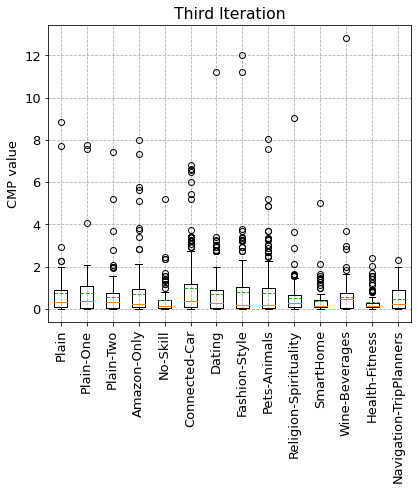

In [356]:
fig, ax = plt.subplots()
_ = ax.boxplot(data, showfliers=True, manage_ticks=True,autorange=True,meanline=True,showmeans=True)

ax.set_ylabel('CMP value')
ax.set_xticks(x_data)
ax.set_xticklabels(control_list + test_list, rotation=90)

# ax.legend(loc="upper left")
# ax.set_ylim([0,13])
# ax.set_yticks([0.5]*20)
fig.set_size_inches(6, 7, forward=True)



plt.title("Third Iteration")
plt.grid(linestyle='--')
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig(RESULTS_DIR + "all_bids_scatter.pdf")
plt.show()

In [359]:
top_points = _["fliers"][0].get_data()[1]
bottom_points = _["fliers"][2].get_data()[1]

IndexError: tuple index out of range

In [358]:
len(top_points), len(bottom_points)

(5, 9)

In [228]:
import itertools

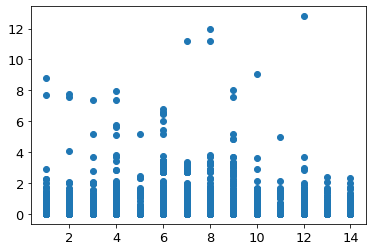

In [229]:
x_index = [[i+1]*len(data[i]) for i,item in enumerate(data)]
# x, y = np.meshgrid(x_zeros,data)
x_index = list(itertools.chain.from_iterable(x_index))
y_index = list(itertools.chain.from_iterable(data))
plt.scatter(x_index,y_index)
plt.show()

In [305]:
from scipy import stats

In [304]:
# ! pip install scipy

In [ ]:
1 – (2U)/(n1 n2)

In [346]:
table = PrettyTable(['Persona', 'Plain(P)', 'Plain(E)', 'Amazon-Only(P)', 'Amazon-Only(E)', 'No-Skill(P)', 'No-Skill(E)'], hrules=ALL)
# for control_persona in ['Plain', 'Amazon-Only', 'No-Skill']:
for test_persona in test_list:
    plain_mu = stats.mannwhitneyu(cpms_personas['Plain'], cpms_personas[test_persona])
    Amazn_mu = stats.mannwhitneyu(cpms_personas['Amazon-Only'], cpms_personas[test_persona])
    NoSkl_mu = stats.mannwhitneyu(cpms_personas['No-Skill'], cpms_personas[test_persona])
    
    plain_p = "{0:0.5f}".format(plain_mu.pvalue)
    Amazn_p = "{0:0.5f}".format(Amazn_mu.pvalue)
    NoSkl_p = "{0:0.5f}".format(NoSkl_mu.pvalue)
    
    plain_e = "{0:0.5f}".format(1 - ((2 * plain_mu.statistic) / (len(cpms_personas['Plain'])*len(cpms_personas[test_persona]))))
    Amazn_e = "{0:0.5f}".format(1 - ((2 * Amazn_mu.statistic) / (len(cpms_personas['Amazon-Only'])*len(cpms_personas[test_persona]))))
    NoSkl_e = "{0:0.5f}".format(1 - ((2 * NoSkl_mu.statistic) / (len(cpms_personas['No-Skill'])*len(cpms_personas[test_persona]))))


    table.add_row([test_persona, plain_p, plain_e, Amazn_p, Amazn_e, NoSkl_p, NoSkl_e])
#         print(control_persona, test_persona, stats.mannwhitneyu(cpms_personas[control_persona], cpms_personas[test_persona]).pvalue)
print(table)

+-------------------------+----------+----------+----------------+----------------+-------------+-------------+
|         Persona         | Plain(P) | Plain(E) | Amazon-Only(P) | Amazon-Only(E) | No-Skill(P) | No-Skill(E) |
+-------------------------+----------+----------+----------------+----------------+-------------+-------------+
|      Connected-Car      | 0.37576  | 0.06542  |    0.06807     |    0.10190     |   0.00004   |   0.29145   |
+-------------------------+----------+----------+----------------+----------------+-------------+-------------+
|          Dating         | 0.40489  | -0.06358 |    0.57135     |    -0.03344    |   0.02756   |   0.16198   |
+-------------------------+----------+----------+----------------+----------------+-------------+-------------+
|      Fashion-Style      | 0.24349  | -0.08969 |    0.24385     |    -0.06968    |   0.19287   |   0.09653   |
+-------------------------+----------+----------+----------------+----------------+-------------+-------

In [349]:
table = PrettyTable(['Persona', 'Plain', 'Amazon-Only', 'No-Skill'], hrules=ALL)
# for control_persona in ['Plain', 'Amazon-Only', 'No-Skill']:
for test_persona in test_list:
    plain_mu = stats.mannwhitneyu(cpms_personas['Plain'], cpms_personas[test_persona])
    Amazn_mu = stats.mannwhitneyu(cpms_personas['Amazon-Only'], cpms_personas[test_persona])
    NoSkl_mu = stats.mannwhitneyu(cpms_personas['No-Skill'], cpms_personas[test_persona])
    
    plain_p = "{0:0.5f}".format(plain_mu.pvalue)
    Amazn_p = "{0:0.5f}".format(Amazn_mu.pvalue)
    NoSkl_p = "{0:0.5f}".format(NoSkl_mu.pvalue)
    
    plain_e = "{0:0.5f}".format(1 - ((2 * plain_mu.statistic) / (len(cpms_personas['Plain'])*len(cpms_personas[test_persona]))))
    Amazn_e = "{0:0.5f}".format(1 - ((2 * Amazn_mu.statistic) / (len(cpms_personas['Amazon-Only'])*len(cpms_personas[test_persona]))))
    NoSkl_e = "{0:0.5f}".format(1 - ((2 * NoSkl_mu.statistic) / (len(cpms_personas['No-Skill'])*len(cpms_personas[test_persona]))))


    table.add_row([test_persona, plain_p, Amazn_p, NoSkl_p])
#         print(control_persona, test_persona, stats.mannwhitneyu(cpms_personas[control_persona], cpms_personas[test_persona]).pvalue)

plain_mu = stats.mannwhitneyu(cpms_personas['Plain'], cpms_personas['No-Skill'])
Amazn_mu = stats.mannwhitneyu(cpms_personas['Amazon-Only'], cpms_personas['No-Skill'])

plain_p = "{0:0.5f}".format(plain_mu.pvalue)
Amazn_p = "{0:0.5f}".format(Amazn_mu.pvalue)

table.add_row(['No-Skill', plain_p, Amazn_p, '--'])

print(table)

ptable_to_csv(table, RESULTS_DIR + 'u-test.csv')

+-------------------------+---------+-------------+----------+
|         Persona         |  Plain  | Amazon-Only | No-Skill |
+-------------------------+---------+-------------+----------+
|      Connected-Car      | 0.37576 |   0.06807   | 0.00004  |
+-------------------------+---------+-------------+----------+
|          Dating         | 0.40489 |   0.57135   | 0.02756  |
+-------------------------+---------+-------------+----------+
|      Fashion-Style      | 0.24349 |   0.24385   | 0.19287  |
+-------------------------+---------+-------------+----------+
|       Pets-Animals      | 0.31971 |   0.61057   | 0.02359  |
+-------------------------+---------+-------------+----------+
|  Religion-Spirituality  | 0.19369 |   0.48389   | 0.00883  |
+-------------------------+---------+-------------+----------+
|        SmartHome        | 0.00166 |   0.00733   | 0.84671  |
+-------------------------+---------+-------------+----------+
|      Wine-Beverages     | 0.38130 |   0.65899   | 0.0

In [319]:
stats.normaltest(cpms_personas['Amazon-Only'])

NormaltestResult(statistic=223.4378973011258, pvalue=3.0274506815191588e-49)